In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
from tqdm.notebook import tqdm
import equinox as eqx
from jax.random import PRNGKey, split
import src.InferenceModel as Infer
from src.utils.miscellaneous import dict_to_namedtuple
from src.utils.trace_dataset import load_traces
from pathlib import Path
from experiments.bayes3d.bayes3d import SceneSampler
from numpyro.handlers import trace, substitute

import bayes3d as j

In [5]:
metadata = load_traces("tmp/1k_bayes3d_metadata.pkl")
metadata = dict_to_namedtuple(metadata)

c = Infer.InferenceModelCfg(
metadata=metadata,
d_model = 128,
dropout_rate = 0.1,
discrete_mlp_width = 512,
discrete_mlp_depth=1,
continuous_flow_blocks=8,
continuous_flow_num_layers_per_block=2,
continuous_flow_num_augment=91,
num_enc_layers=5,
max_discrete_choices =6,
num_input_variables = (225,1),
num_observations =100,
)

inference = Infer.InferenceModel(key=PRNGKey(0),c=c)

In [6]:
inference = eqx.tree_deserialise_leaves("tmp/500k_bayes3d.eqx", inference)
inference = eqx.tree_inference(inference, True)

Python 3.8.16 (default, Mar  2 2023, 03:21:46) 
Type 'copyright', 'credits' or 'license' for more information
IPython 8.12.2 -- An enhanced Interactive Python. Type '?' for help.



> /home/aldo/miniconda3/envs/tfp-jax/lib/python3.8/site-packages/equinox/_serialisation.py(142)_assert_same()
    141             from ipdb import set_trace; set_trace()
--> 142             raise RuntimeError(
    143                 f"Deserialised leaf has changed shape from {old.shape} in `like` to "



[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (160, 160, 512)


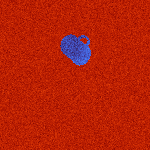

In [ ]:
sampler = SceneSampler(
                        # mesh_paths=[Path("sample_objs/bunny.obj")],
                        mesh_paths=[Path("ycb_video_models/models/025_mug/textured_simple.obj")],
                        num_objects=1,
                        max_pose_xy_noise=0.3,
                        )
sampler_ = lambda key: sampler(key, noise=False)
seed = PRNGKey(1234)
tr = trace(sampler_).get_trace(key=seed)
img, flattened_patches, obs = sampler_(key=seed)
gt_img = sampler.reconsctruct_from_patches(obs, (150,150), 15)
gt_img = j.viz.get_depth_image(gt_img)
gt_img

In [ ]:
k = split(PRNGKey(90996899),200)[134]
inference.rsample(obs, sampler_, k)

/home/aldo/miniconda3/envs/tfp-jax/lib/python3.8/site-packages/jax/_src/numpy/array_methods.py:322: FutureWarning: The arr.split() method is deprecated. Use jax.numpy.split instead.
  warnings.warn(


Python 3.8.16 (default, Mar  2 2023, 03:21:46) 
Type 'copyright', 'credits' or 'license' for more information
IPython 8.12.2 -- An enhanced Interactive Python. Type '?' for help.



















rot_0_u0

{'type': 'sample', 'name': 'rot_0_u0', 'fn': <numpyro.distributions.continuous.Uniform object at 0x7efecc063820>, 'args': (), 'kwargs': {'rng_key': Array([1909954642, 1858953717], dtype=uint32), 'sample_shape': ()}, 'value': Array(0.11604917, dtype=float32), 'scale': None, 'is_observed': False, 'intermediates': [], 'cond_indep_stack': [], 'infer': {}}

---------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
File ~/CNF-diff-probprog/src/InferenceModel.py:302, in InferenceModel.rsample(self, obs, gen_model_sampler, key)
    301 try:
--> 302   exec_trace = trace(sub_model).get_trace(sk3)
    303 except:

File ~/miniconda3/envs/tfp-jax/lib/python3.8/site-packages/numpyro/handlers.py:171, in 

/home/aldo/miniconda3/envs/tfp-jax/lib/python3.8/site-packages/jax/_src/numpy/array_methods.py:322: FutureWarning: The arr.split() method is deprecated. Use jax.numpy.split instead.
  warnings.warn(


Python 3.8.16 (default, Mar  2 2023, 03:21:46) 
Type 'copyright', 'credits' or 'license' for more information
IPython 8.12.2 -- An enhanced Interactive Python. Type '?' for help.



In [7]:
samples_and_log_p = [inference.rsample(obs, sampler_, k) for k in tqdm(split(PRNGKey(90996899), 200))]
all_log_p = map(lambda x: x[2], samples_and_log_p)
all_samples = map(lambda x: x[0], samples_and_log_p)

best = np.argmax(all_log_p)
sampled_variables = all_samples[best]

model_pred = substitute(sampler_, sampled_variables)
img_, flattened_patches_, obs_ = model_pred(PRNGKey(5343))
pred_img = sampler.reconsctruct_from_patches(flattened_patches_, (150,150), 15)
pred_img = j.viz.get_depth_image(pred_img)
pred_img

  0%|          | 0/200 [00:00<?, ?it/s]

/home/aldo/miniconda3/envs/tfp-jax/lib/python3.8/site-packages/jax/_src/numpy/array_methods.py:322: FutureWarning: The arr.split() method is deprecated. Use jax.numpy.split instead.
  warnings.warn(


ValueError: Found zero norm quaternions in `quat`.